In [29]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Bitstream Vera Sans",
#    "font.sans-serif": "Helvetica",
})

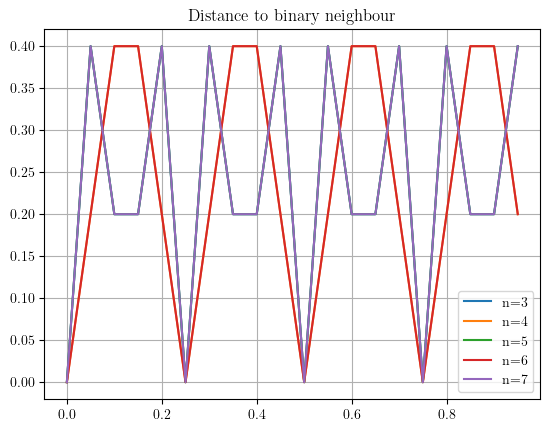

In [46]:
a = [i/20 for i in range(20)]

def dist(a: list, t: int):
    binaries = [i*2**(-t) for i in range(2**t+1)]
    distance = []
    for i in a:
        distance.append(1)
        for j in binaries:
            if np.abs(i-j) < distance[a.index(i)]:
                distance[a.index(i)] = np.abs(i-j)
        distance[a.index(i)] = distance[a.index(i)]/(2**(-t))
    return distance

hmm3 = dist(a, 3)
hmm4 = dist(a, 4)
hmm5 = dist(a, 5)
hmm6 = dist(a, 6)
hmm7 = dist(a, 7)



plt.plot(a, hmm3, label="n=3")
plt.plot(a, hmm4, label="n=4")
plt.plot(a, hmm5, label="n=5")
plt.plot(a, hmm6, label="n=6")
plt.plot(a, hmm7, label="n=7")
plt.legend()
plt.grid()
plt.title("Distance to binary neighbour")
plt.show()

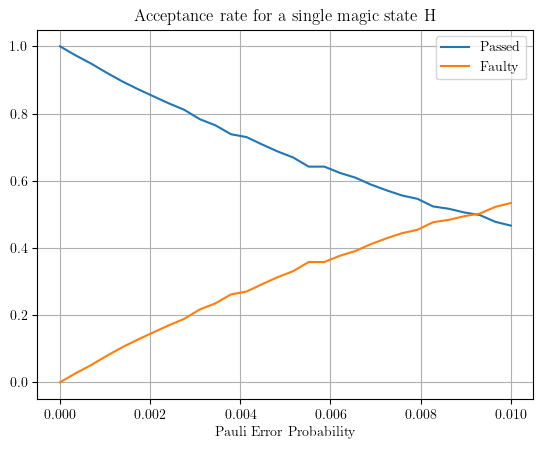

In [32]:
def magicH():  
    qc = QuantumCircuit(7+2,)
    state_inj = ClassicalRegister(14)
    qc.add_register(state_inj)

    anc = qc.num_qubits - 1
    ancc = anc - 1

    for i in range(9):                        #start noise
        qc.id(i)

    qc.h(0)
    qc.h(1)
    qc.ry(np.pi/4,2)
    qc.h(3)

    qc.cx(2,4)
    qc.cx(0,6)

    qc.cx(3,5)

    qc.cx(2,5)

    qc.cx(0,4)
    qc.cx(1,6)

    qc.cx(0,2)

    qc.cx(1,5)

    qc.cx(1,2)
    qc.cx(3,4)
    qc.cx(3,6)
    #################################Controlled Hadamards##########################################
    qc.h(ancc)
    for i in range(7):
        #qc.ch(anc-1,6-i+2*7)
        qc.ry(-np.pi/4,6-i)
        qc.cz(ancc,6-i)
        qc.ry(np.pi/4,6-i)
        if i == 0:
            qc.cx(ancc,anc)
        if i == 5:
            qc.cx(ancc,anc)
    qc.h(ancc)
    qc.measure(ancc, state_inj[0])
    qc.measure(anc, state_inj[1])
    ##########################################QEC Block#######################################
    qc.reset(anc), qc.reset(ancc)
    ##################################Z-Stabilizers##########################################
    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(0, anc)
    qc.cx(2, anc)
    qc.cx(4, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[2]), qc.measure(ancc, state_inj[8])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(ancc, anc)
    qc.cx(1, anc)
    qc.cx(2, anc)
    qc.cx(ancc, anc)
    qc.cx(5, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[3]), qc.measure(ancc, state_inj[9])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(ancc, anc)
    qc.cx(3, anc)
    qc.cx(4, anc)
    qc.cx(ancc, anc)
    qc.cx(5, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[4]), qc.measure(ancc, state_inj[10])
    qc.reset(anc), qc.reset(ancc)
    ##################################X-Stabilizers##############################################
    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, 0)
    qc.cx(anc, 2)
    qc.cx(anc, 4)
    qc.cx(anc, 6)
    qc.h(anc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[5]), qc.measure(ancc, state_inj[11])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, ancc)
    qc.cx(anc, 1)
    qc.cx(anc, 2)
    qc.cx(anc, ancc)
    qc.cx(anc, 5)
    qc.cx(anc, 6)
    qc.h(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[6]), qc.measure(ancc, state_inj[12])
    qc.reset(anc)

    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, ancc)
    qc.cx(anc, 3)
    qc.cx(anc, 4)
    qc.cx(anc, ancc)
    qc.cx(anc, 5)
    qc.cx(anc, 6)
    qc.h(anc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[7]), qc.measure(ancc, state_inj[13])
    return qc

def testreadout(qc: QuantumCircuit, shots: int, noise: float):
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "id", "ry"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx',"cz"])  # Apply to 2-qubit gates
    
    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()

    bits = list(counts.keys())
    hmm = list(counts.values())

    nah, valid = 0,0

    for i in range(len(bits)):
        if bits[i].count("1") != 0:
            bits[i] = "nope"
            nah += hmm[i]
        else:
            valid += hmm[i]
    
    nah = nah/shots
    valid = valid/shots

    return valid, nah

qc = magicH()

y,z = [],[]

x = np.linspace(0,0.01,30)
for i in x:
    qc = magicH()
    yes, ney = testreadout(qc, 10000, i)
    y.append(yes), z.append(ney)

plt.plot(x,y,label="Passed")
plt.plot(x,z,label="Faulty")
plt.xlabel("Pauli Error Probability")
plt.grid()
plt.title("Acceptance rate for a single magic state H")
plt.legend()
plt.show()

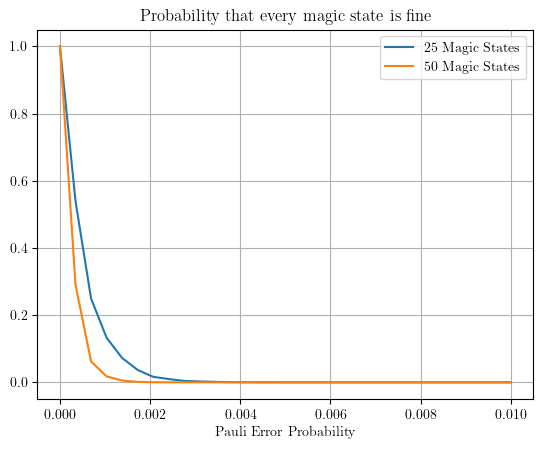

In [31]:
y25 = [i**25 for i in y]

y50 = [i**50 for i in y]

plt.plot(x,y25,label="25 Magic States")
plt.plot(x,y50,label="50 Magic States")
plt.grid()
plt.xlabel("Pauli Error Probability")
plt.legend()
plt.title("Probability that every magic state is fine")
plt.show()